In [1]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix' # latex like
matplotlib.rcParams['font.family'] = 'STIXGeneral' # latex like

## Part 1

#### 1. Derive the corresponding Boundary Value Problem (BVP) for the displacement field u : [0, L]→R using the equilibrium equation for 1D problems (strong form).

Define variables

In [2]:
x = sp.Symbol('x',real=True)
u = sp.Function('u',real=True)(x)
u_xx = u.diff(x,2)
L, g, F, A, E = sp.symbols('L g F A E')
rho = sp.pi**3/L**2
s = g*sp.pi**4/L**2
r = (x/L)**2
b = g*sp.pi**2/L

Define the differential equation

In [3]:
ode = sp.Eq(u_xx + rho*u - s*r,0)
display(ode)

Eq(Derivative(u(x), (x, 2)) + pi**3*u(x)/L**2 - pi**4*g*x**2/L**4, 0)

---

#### 2. Find the exact solution of this BVP. Plot in a graph the solution of the problem using the following values of the involved constants and the function r = r(x/L):

Solve the differential equation

In [4]:
sol = sp.dsolve(ode, ics={u.subs(x,0):-g, u.diff(x).subs(x,L):b})
display(sol)

Eq(u(x), -2*g/pi**2 + (-pi**(7/2)*g + 2*pi**(3/2)*g - I*pi**4*g*exp(I*pi**(3/2)) + 2*I*pi**3*g*exp(I*pi**(3/2)))*exp(I*pi**(3/2)*x/L)/(pi**(7/2) + pi**(7/2)*exp(2*I*pi**(3/2))) + (-2*I*pi**3*g*exp(I*pi**(3/2)) + 2*pi**(3/2)*g*exp(2*I*pi**(3/2)) - pi**(7/2)*g*exp(2*I*pi**(3/2)) + I*pi**4*g*exp(I*pi**(3/2)))*exp(-I*pi**(3/2)*x/L)/(pi**(7/2) + pi**(7/2)*exp(2*I*pi**(3/2))) + pi*g*x**2/L**2)

In [5]:
# print(sol.free_symbols)
u_sol = sp.lambdify((x,L,g),sol.rhs)

In [6]:
x_range = np.linspace(0,1,100)
L, g = 1, 0.01

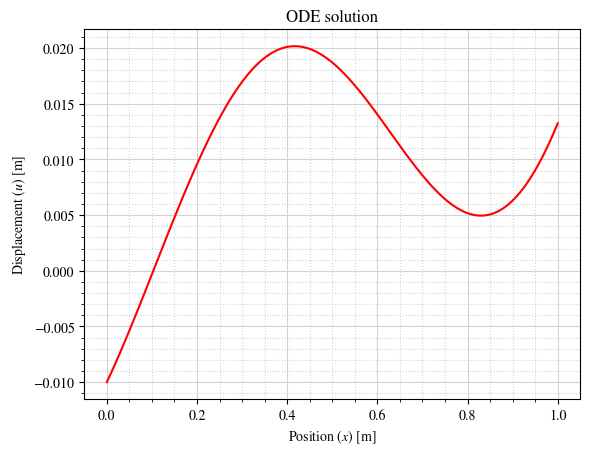

In [7]:
plt.title('ODE solution')
plt.plot(x_range,np.real(u_sol(x_range,L,g)), color='r')
plt.xlabel('Position ($x$) [m]')
plt.ylabel('Displacement ($u$) [m]')
plt.minorticks_on()
plt.grid(True, which='major', zorder=0, color='lightgray', linestyle='-')
plt.grid(True, which='minor', zorder=-1, color='lightgray', linestyle=':')
plt.savefig('figures/solution1.svg',format="svg")
plt.show()

---

#### 3. Formulate the Variational (or Weak) form of the Boundary Value Problem.

In [8]:
v = sp.Function('v')(x)
L,g = sp.symbols('L,g')
b = g*sp.pi**2/L
v_x = v.diff(x)
u_x = u.diff(x)
f = rho*u - s*r

In [9]:
v_x*u_x

Derivative(u(x), x)*Derivative(v(x), x)

In [10]:
weak_form = sp.Eq(sp.Integral(v_x*u_x,(x,0,L)),sp.Integral(v*f,(x,0,L)) + b*v.subs(x,1))
display(weak_form)

Eq(Integral(Derivative(u(x), x)*Derivative(v(x), x), (x, 0, L)), Integral((pi**3*u(x)/L**2 - pi**4*g*x**2/L**4)*v(x), (x, 0, L)) + pi**2*g*v(1)/L)

---

#### 5. Seek an approximation to the solution of this weak form by using basis polynomial basis functions of increasing order (up to order 6)

In [11]:
# # Define a symbolic size 'n'
# n = sp.symbols('n', integer=True)
# # Define a symbolic row vector 'N' with 1 row and n columns
# N = sp.MatrixSymbol('N', 1, n)
# B = sp.MatrixSymbol('B', 1, n)
# c = sp.MatrixSymbol('c', n, 1)
# d = sp.MatrixSymbol('d', n, 1)
# v_x = B*c
# u_x = B*d
# v = N*c
# u = N*d

In [12]:
def solve_u(g_,L_,n):
   '''Returns the function of the displacement: u(x)'''
   # Defining variables
   c = sp.symbols(f'c_1:{n+2}')  # Generates c_1, c_2, ..., c_n
   d = sp.symbols(f'd_1:{n+2}')  # Generates c_1, c_2, ..., c_n
   c = sp.Matrix(c)
   c[0] = 0
   d = sp.Matrix(d)
   N = sp.Matrix([x**i for i in range(n+1)]).T
   B = N.diff()
   K = sp.integrate(B.T*B,(x,0,L))
   A = sp.integrate(rho*N.T*N,(x,0,L))
   D = -((sp.integrate(s/L**2*N.T*x**2,(x,0,L))) - b*N.T.subs(x,1))

   # Define the system
   K_ll = K[1:,1:] - A[1:,1:]
   K_lr = (K[1:,0] - A[1:,0])
   dr = d[0,:]
   Dl = D[1:,:]

   # Converting from symbolic to numeric for efficiency (from sympy to numpy)
   A_system = sp.lambdify(L,K_ll)(L_)
   b_system = sp.lambdify((L,g,dr[0]),Dl-K_lr*dr)(L_,g_,-g_)
   sols = np.linalg.solve(A_system,b_system)
   sols = np.insert(sols.flatten(),0,-g_)

   # Defining the function of the solution
   u_func = sp.lambdify(x,(N*sols).flatten().sum())
   return u_func

In [13]:
g_ = 0.01
L_ = 1
u_funcs = [np.vectorize(solve_u(g_=g_,L_=L_,n=i)) for i in range(1,7)]

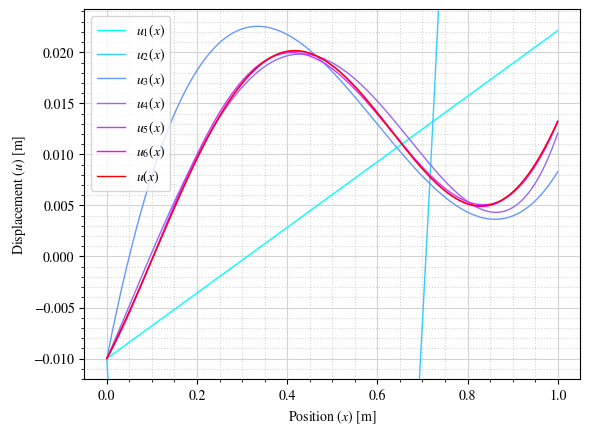

In [14]:
x_range = np.linspace(0,1,int(1e3))
u_funcs_eval = [u_func(x_range) for u_func in u_funcs]
u_sol_eval = np.real(u_sol(x=x_range,L=L_,g=g_))

ax = plt.subplot(1,1,1)
color_idx = np.linspace(0, 1, len(u_funcs))


for i, u_func_eval in enumerate(u_funcs_eval):
    plt.plot(x_range, u_func_eval, label=f'$u_{i+1}(x)$', color=plt.cm.cool(color_idx[i]), linestyle='-', lw=1)

plt.plot(x_range,u_sol_eval, label='$u(x)$', color='r', linestyle='-', lw=1)

plt.xlabel('Position ($x$) [m]')
plt.ylabel('Displacement ($u$) [m]')
plt.minorticks_on()
plt.grid(True, which='major', zorder=0, color='lightgray', linestyle='-')
plt.grid(True, which='minor', zorder=-1, color='lightgray', linestyle=':')
plt.ylim(min(u_sol_eval)*1.2,max(u_sol_eval)*1.2)
plt.savefig('figures/solution2.svg',format="svg")
plt.legend()
plt.show()

---

#### 6. Solve the weak form using linear finite element basis functions. Employ equally sized finite elements

In [15]:
import scipy as sc
# import random

In [16]:
nel = 10
nnod = nel+1
L = 1
rho = np.pi**3/L**2
he = L/nel
he_ = sp.symbols('h_e')
# Ke = np.array([[1, -1],[-1, 1]])/he
ke = [1/he for i in range(nel)] # In case the Ke was not the same for every element, to know what value is associated with each one (generalization)

In [17]:
CN = np.array([[i+1, i+2] for i in range(nel)]) # Element connectivity matrix (node A is connected with node B, its row is the number of the element)

In [36]:
# Symbolic calculation of Ke and transforming to numeric
xi = sp.symbols('xi')
Ne = 1/2*sp.Matrix([(1-xi),(1+xi)]).T
Be = sp.diff(Ne,xi)*(2/he_) # dx/dξ = he/2 (Be = d(Ne)/dx = d(Ne)/dξ * dξ/dx)
K1 = sp.integrate(Be.T*Be,(xi,-1,1))*(he_/2)
K2 = rho*sp.integrate((Ne.T*Ne),(xi,-1,1))*(he_/2)
Ke_ = K1 - K2 # symbolic
Ke = np.array(Ke_.subs(he_,he)).astype(np.float64) # numeric

In [18]:
Kcoo = sc.sparse.coo_matrix(([0],([0],[0])), shape=(nnod,nnod)) # definition of a sparse matrix full of zeros
Klil = Kcoo.tolil() # for easy modification

In [19]:
CN_index_corrected = CN - 1
for el,(i,j) in enumerate(CN_index_corrected):
    # ke = np.array([[],[]])
    Klil[i,i] += ke[el]
    Klil[j,j] += ke[el]
    Klil[i,j] -= ke[el]
    Klil[j,i] -= ke[el]
    # for (a,b) in ke
del CN_index_corrected

K = Klil.tocsr() # more efficient for operations
K.__sizeof__()

24

In [ ]:
plt.spy(K)